6 September 2019: This notebook serves to investigate the influence of different timesteps, $\Delta t$, in the advection step. The default step used in most particle runs so far is 5 seconds. One run, ``control_y300_P3590x590_S2000-1-1_D90_DT60_ODT12_LAT60.5-89.5_LON-179.5-179.5`` has a time step of 60 seconds. The particle set of this run can be compared to ``pset_control_y300_P3590x590_S2000-1-1_D30_DT5_ODT12_LAT60.5-89.5_LON-179.5-179.5``, since all settings, except for the _runtime_ and $\Delta t$ are equal.

In [30]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.collections as mc
import xarray as xr
import matplotlib.pyplot as plt
import cartopy as cart
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from importlib import reload
import sys
sys.path.append('/home/students/4302001/arctic-connectivity/tools')
sys.path.append('/Users/daanreijnders/surfdrive/Thesis/repo/tools')
import plot
import lifeline
import comtools
import fieldsetter
import advectParticles

In [2]:
pset_path = '/data/oceanparcels/output_data/data_Daan/psets/'

In [3]:
ds_dt1  = xr.open_dataset(pset_path+'pset_control_y300_P3590x590_S2000-1-1_D30_DT1_ODT12_LAT60.5-89.5_LON-179.5-179.5.nc')
ds_dt5  = xr.open_dataset(pset_path+'pset_control_y300_P3590x590_S2000-1-1_D30_DT5_ODT12_LAT60.5-89.5_LON-179.5-179.5.nc')
ds_dt20 = xr.open_dataset(pset_path+'pset_control_y300_P3590x590_S2000-1-1_D30_DT20_ODT12_LAT60.5-89.5_LON-179.5-179.5.nc')
ds_dt60a = xr.open_dataset(pset_path+'pset_control_y300_P3590x590_S2000-1-1_D90_DT60_ODT12_LAT60.5-89.5_LON-179.5-179.5.nc')
ds_dt60b = xr.open_dataset(pset_path+'pset_control_y300_alt_P3590x590_S2000-1-1_D30_DT60_ODT12_LAT60.5-89.5_LON-179.5-179.5.nc')

In [4]:
print('Technical data')
print('--------------')
print('-----dt1------')
print('--------------')
print(ds_dt1)
print('--------------')
print('-----dt5------')
print('--------------')
print(ds_dt5)
print('--------------')
print('-----dt20------')
print('--------------')
print(ds_dt20)
print('--------------')
print('-----dt60a-----')
print('--------------')
print(ds_dt60a)
print('--------------')
print('-----dt60b-----')
print('--------------')
print(ds_dt60b)

Technical data
--------------
-----dt1------
--------------
<xarray.Dataset>
Dimensions:     (obs: 61, traj: 2118100)
Dimensions without coordinates: obs, traj
Data variables:
    trajectory  (traj, obs) float64 ...
    time        (traj, obs) datetime64[ns] ...
    lat         (traj, obs) float32 ...
    lon         (traj, obs) float32 ...
    z           (traj, obs) float32 ...
Attributes:
    feature_type:                    trajectory
    Conventions:                     CF-1.6/CF-1.7
    ncei_template_version:           NCEI_NetCDF_Trajectory_Template_v2.0
    parcels_version:                 2.0.1.dev269+g1687de9
    parcels_mesh:                    spherical
    dt:                              0:01:00
    Output dt:                       12:00:00
    Runtime:                         30 days, 0:00:00
    Release time of first particle:  2000-01-01 00:00:00
--------------
-----dt5------
--------------
<xarray.Dataset>
Dimensions:     (obs: 61, traj: 2118100)
Dimensions without co

# Indices

``ds_dt60a`` covers a time span of 90 days, while ``ds_dt1``, ``ds_dt5`` and ``ds_dt20`` cover a time span of 30 days, This means we have to be careful with choosing the correct value in ``ds_dt60a`` so we match up our data with ``ds_dt5``. The correct index is ``60``:

In [5]:
ds_dt60a.time[0,-1].values

numpy.datetime64('2000-03-31T00:00:00.000000000')

In [6]:
ds_dt1.time[0,-1].values

numpy.datetime64('2000-01-31T00:00:00.000000000')

In [7]:
ds_dt5.time[0,-1].values

numpy.datetime64('2000-01-31T00:00:00.000000000')

In [8]:
ds_dt20.time[0,-1].values

numpy.datetime64('2000-01-31T00:00:00.000000000')

In [9]:
ds_dt60a.time[0,60].values

numpy.datetime64('2000-01-31T00:00:00.000000000')

In [10]:
ds_dt60b.time[0,60].values

numpy.datetime64('2000-01-31T00:00:00.000000000')

# Position comparison
Since both simulations stem from the same original particle grid, we can readily compare the final positions of the particles. This can for example be done for particles released along a certain longitude band/meridian. We investigate $0^\circ$, since the prime meridian coincides with the Fram Straight, and should thus only consist of particles in water (as opposed to the trivial case of particles on land).

Note: these simulations were carried out with initial particle grids where particles on land were not yet removed.

## Trajectory index
The initial lat-lon positions are simply stored in sequential order, first going from 179.5W to 179.5E, then going from 60.5N to 89.5N. Therefore, we have to be mindful that when we want to select a meridian, we have to select each 3590th element in our array. ``1795::3590`` selects the prime meridian:

In [11]:
ds_dt1.lon[1795::3590,0]

<xarray.DataArray 'lon' (traj: 590)>
array([0.050014, 0.050014, 0.050014, ..., 0.050014, 0.050014, 0.050014],
      dtype=float32)
Dimensions without coordinates: traj
Attributes:
    long_name:      
    standard_name:  longitude
    units:          degrees_east
    axis:           X

We can check whether all initial positions are equal.

In [13]:
np.all(np.array([np.all(ds_dt1.lon[1795::3590,0] == ds_dt5.lon[1795::3590,0]), 
                 np.all(ds_dt1.lon[1795::3590,0] == ds_dt20.lon[1795::3590,0]),
                 np.all(ds_dt1.lon[1795::3590,0] == ds_dt60a.lon[1795::3590,0]),
                 np.all(ds_dt1.lon[1795::3590,0] == ds_dt60b.lon[1795::3590,0])]))

True

In [14]:
np.all(np.array([np.all(ds_dt1.lat[1795::3590,0] == ds_dt5.lat[1795::3590,0]), 
                 np.all(ds_dt1.lat[1795::3590,0] == ds_dt20.lat[1795::3590,0]),
                 np.all(ds_dt1.lat[1795::3590,0] == ds_dt60a.lat[1795::3590,0]),
                 np.all(ds_dt1.lat[1795::3590,0] == ds_dt60b.lat[1795::3590,0])]))

True

## Drift distances
We can now simply take the euclidian difference between each final location. Note that we use index ``60`` for ``ds_dt60``. First we have to define a function to compute distances using the Haversine formula<sup>[1]</sup>.

[1]: https://medium.com/@petehouston/calculate-distance-of-two-locations-on-earth-using-python-1501b1944d97

In [15]:
def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a)) 
    r = 6371 # Radius of earth in kilometers. Use 3956 for miles
    return c * r

The rest is straightforward:

In [17]:
merid_dist_diff = haversine(ds_dt5.lon[1795::3590,-1],\
                            ds_dt5.lat[1795::3590,-1],\
                            ds_dt60a.lon[1795::3590,60],\
                            ds_dt60a.lat[1795::3590,60])

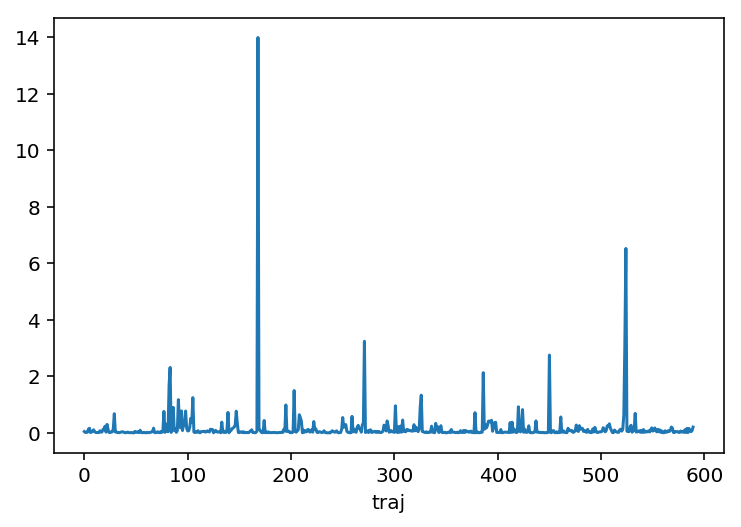

In [18]:
merid_dist_diff.plot()

In [19]:
merid_dist_diff.mean()

<xarray.DataArray ()>
array(0.162516, dtype=float32)

In [20]:
merid_dist_diff.std()

<xarray.DataArray ()>
array(0.70081, dtype=float32)

In [21]:
merid_dist_diff.mean()/30

<xarray.DataArray ()>
array(0.005417)

The mean difference is distance is rather small. Here we see that the largest differences only span around 14 kilometers, but the average is only 162 meters (over the coure of 30 days), meaning a drift of 5 meters a day.

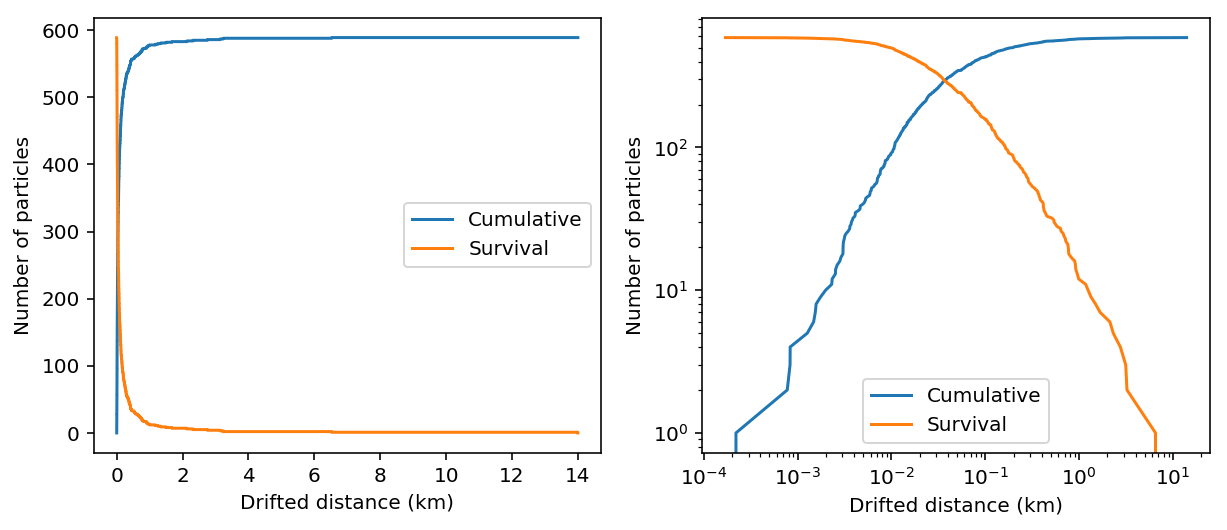

In [22]:
sorted_dists = np.sort(merid_dist_diff)  # Or data.sort(), if data can be modified
fig, axes = plt.subplots(1,2, figsize=(10,4))
axes[0].step(sorted_dists, np.arange(sorted_dists.size), label='Cumulative')  # From 0 to the number of data points-1
axes[0].step(sorted_dists[::-1], np.arange(sorted_dists.size), label='Survival')  # From the number of data points-1 to 0
axes[0].set_xlabel('Drifted distance (km)')
axes[0].set_ylabel('Number of particles')
axes[0].legend()
axes[1].loglog(sorted_dists, np.arange(sorted_dists.size), label='Cumulative')  # From 0 to the number of data points-1
axes[1].loglog(sorted_dists[::-1], np.arange(sorted_dists.size), label='Survival')  # From the number of data points-1 to 0
axes[1].set_xlabel('Drifted distance (km)')
axes[1].set_ylabel('Number of particles')
axes[1].legend()
plt.show()

# Spatial plot

In [55]:
merid_lon_1 = ds_dt1.lon[1795::3590,-1]
merid_lat_1 = ds_dt1.lat[1795::3590,-1]
merid_lon_5 = ds_dt5.lon[1795::3590,-1]
merid_lat_5 = ds_dt5.lat[1795::3590,-1]
merid_lon_20 = ds_dt20.lon[1795::3590,-1]
merid_lat_20 = ds_dt20.lat[1795::3590,-1]
merid_lon_60a = ds_dt60a.lon[1795::3590,60]
merid_lat_60a = ds_dt60a.lat[1795::3590,60]
merid_lon_60b = ds_dt60b.lon[1795::3590,-1]
merid_lat_60b = ds_dt60b.lat[1795::3590,-1]

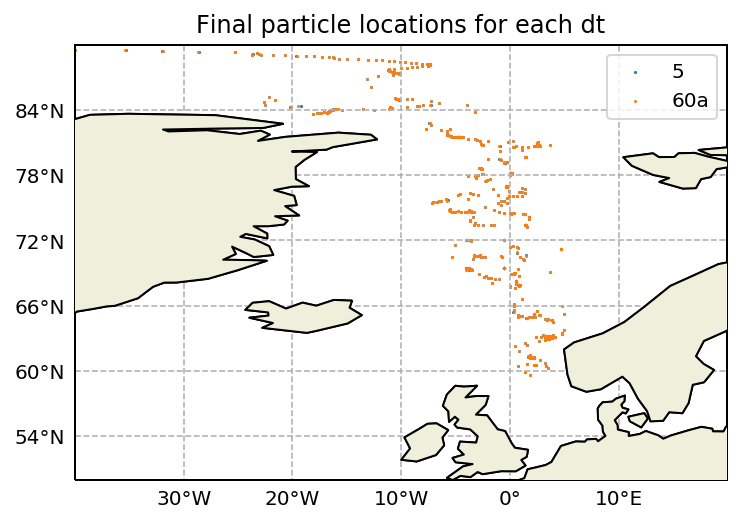

In [57]:
fig     = plt.figure()
ax      = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent((-40,20,50,90), crs=ccrs.PlateCarree())
ax.coastlines()
ax.add_feature(cart.feature.LAND, zorder=5, edgecolor='k')
gl = ax.gridlines(crs=ccrs.PlateCarree(), linestyle='--', draw_labels = True)
gl.xlabels_top   = False
gl.ylabels_right = False
gl.xformatter    = LONGITUDE_FORMATTER
gl.yformatter    = LATITUDE_FORMATTER
ax.scatter(merid_lon_5, merid_lat_5, s=0.3, c='C0', transform=ccrs.PlateCarree(), label='5')
ax.scatter(merid_lon_60a, merid_lat_60a, s=0.3, c='C1', transform=ccrs.PlateCarree(), label='60a')
plt.legend()
plt.title('Final particle locations for each dt')
plt.show()

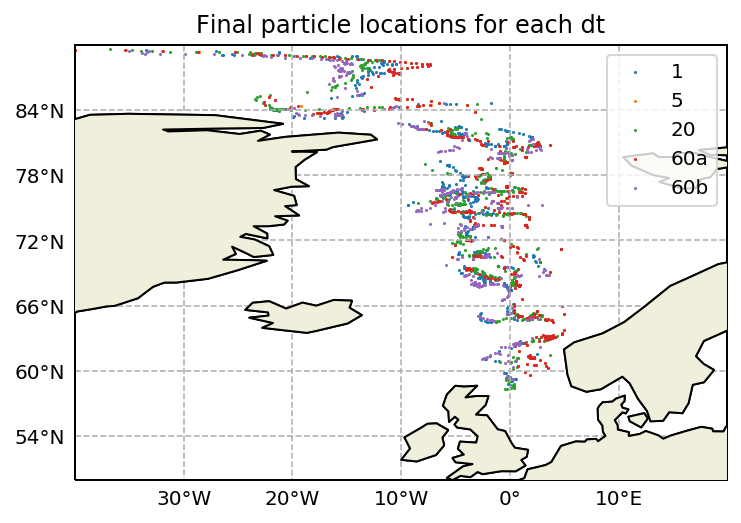

In [56]:
fig     = plt.figure()
ax      = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent((-40,20,50,90), crs=ccrs.PlateCarree())
ax.coastlines()
ax.add_feature(cart.feature.LAND, zorder=5, edgecolor='k')
gl = ax.gridlines(crs=ccrs.PlateCarree(), linestyle='--', draw_labels = True)
gl.xlabels_top   = False
gl.ylabels_right = False
gl.xformatter    = LONGITUDE_FORMATTER
gl.yformatter    = LATITUDE_FORMATTER
ax.scatter(merid_lon_1, merid_lat_1, s=0.3, c='C0', transform=ccrs.PlateCarree(), label='1')
ax.scatter(merid_lon_5, merid_lat_5, s=0.3, c='C1', transform=ccrs.PlateCarree(), label='5')
ax.scatter(merid_lon_20, merid_lat_20, s=0.3, c='C2', transform=ccrs.PlateCarree(), label='20')
ax.scatter(merid_lon_60a, merid_lat_60a, s=0.3, c='C3', transform=ccrs.PlateCarree(), label='60a')
ax.scatter(merid_lon_60b, merid_lat_60b, s=0.3, c='C4', transform=ccrs.PlateCarree(), label='60b')
plt.legend()
plt.title('Final particle locations for each dt')
plt.show()

Here the spread between particle locations does seems large, except for the difference between ``5`` and ``60a``, which were both run before Parcels got parallelized. Let's look at individual distances between trajectories:

In [59]:
psets = {'1' : (merid_lon_1, merid_lat_1),
         '5' : (merid_lon_5, merid_lat_5),
         '20' : (merid_lon_20, merid_lat_20),
         '60a' : (merid_lon_60a, merid_lat_60a),
         '60b' : (merid_lon_60b, merid_lat_60b),
         }

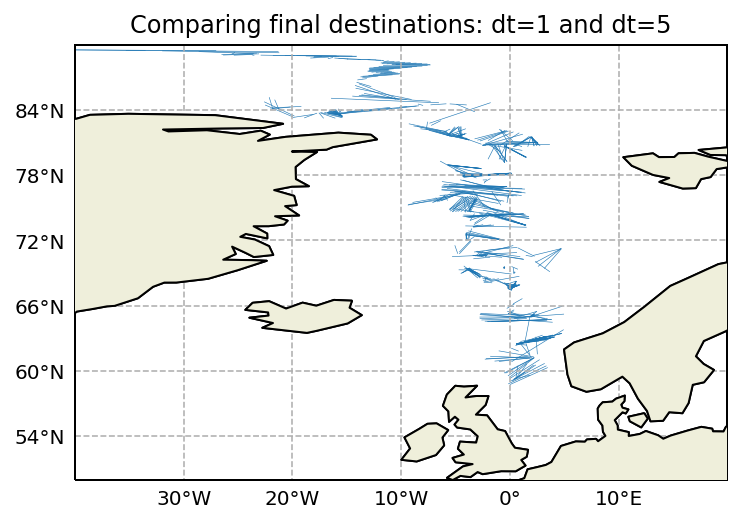

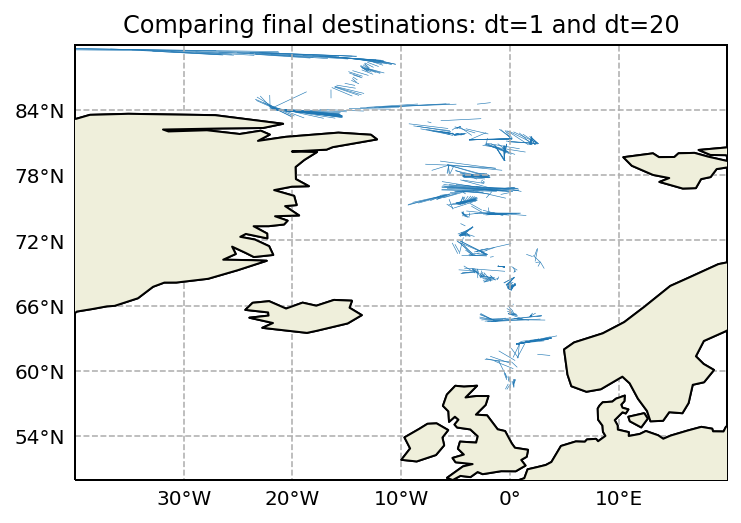

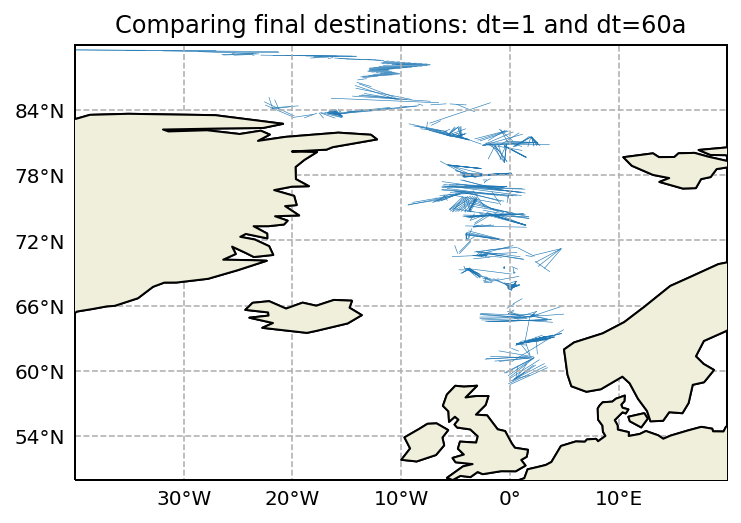

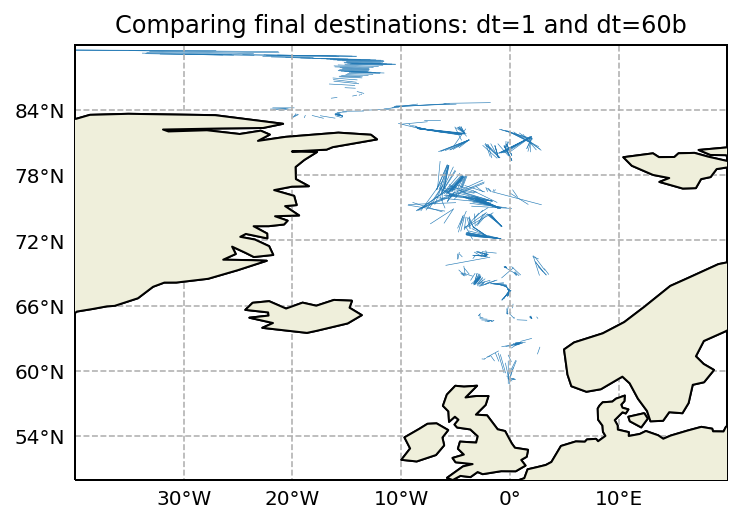

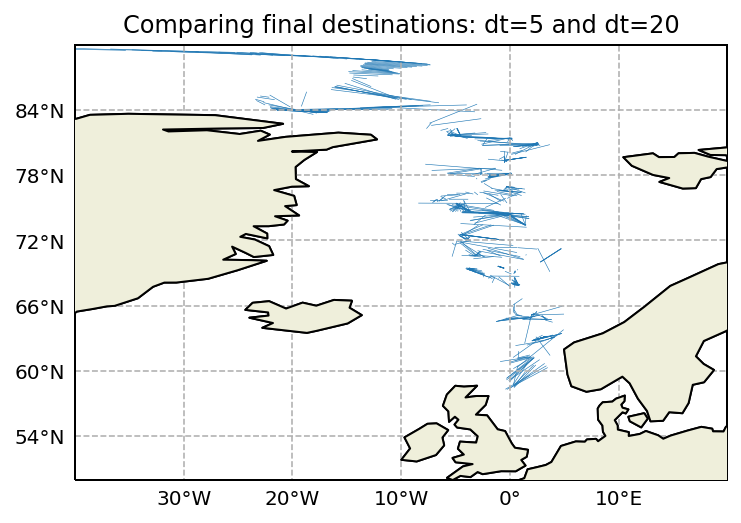

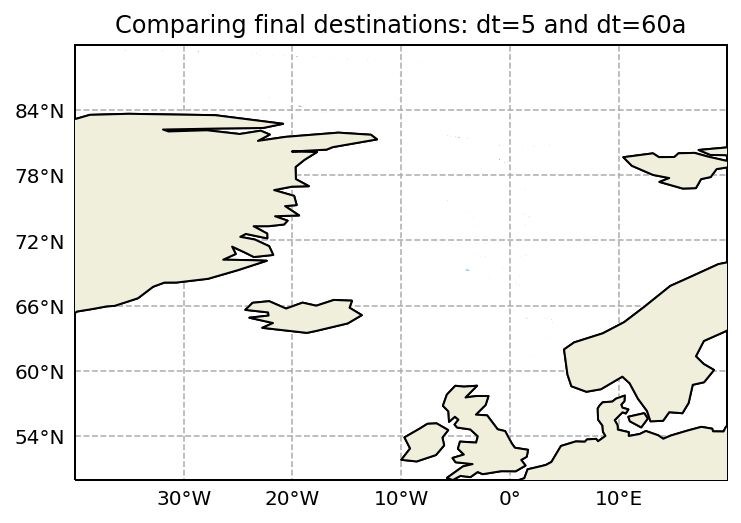

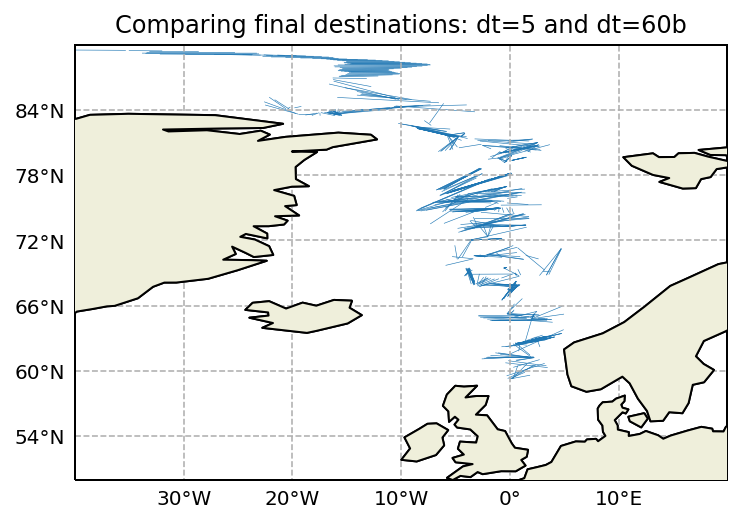

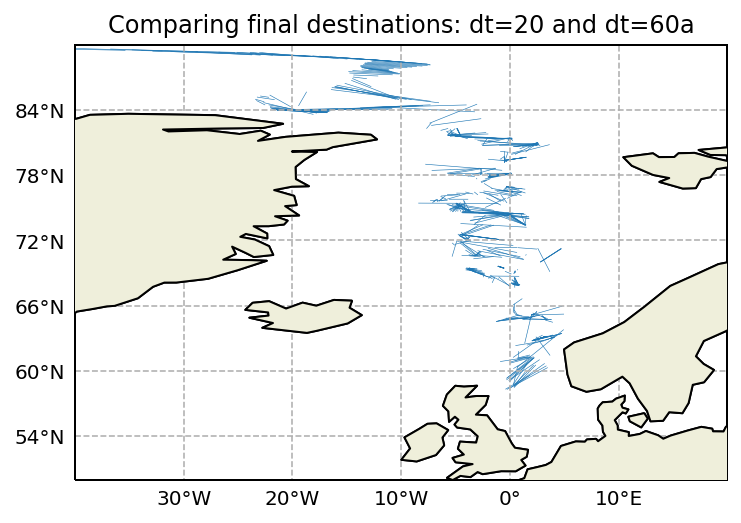

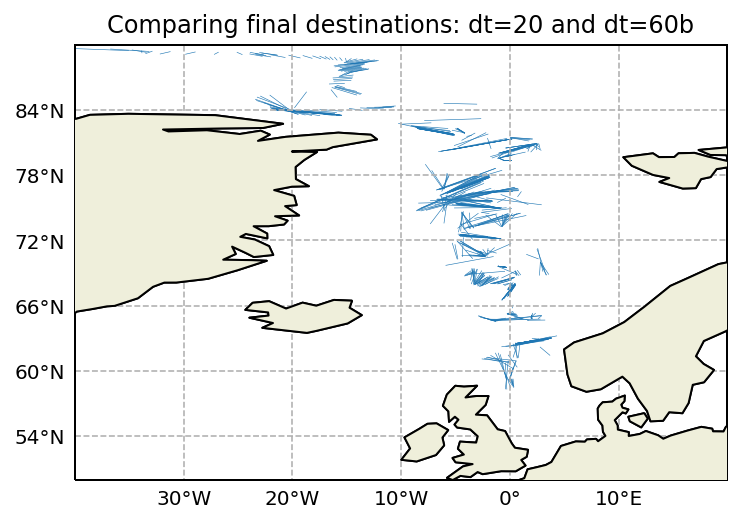

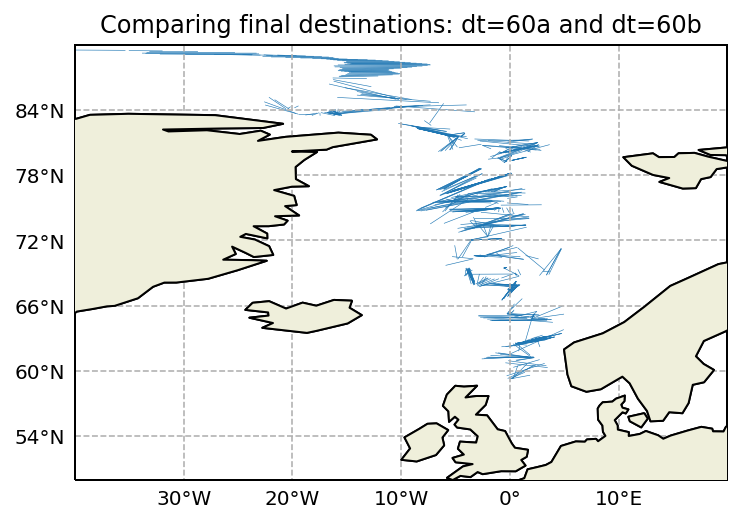

In [60]:
from itertools import combinations
for combo in combinations(psets.keys(), 2):
    fig     = plt.figure()
    ax      = plt.axes(projection=ccrs.PlateCarree())
    ax.set_extent((-40,20,50,90), crs=ccrs.PlateCarree())
    ax.coastlines()
    ax.add_feature(cart.feature.LAND, zorder=5, edgecolor='k')
    gl = ax.gridlines(crs=ccrs.PlateCarree(), linestyle='--', draw_labels = True)
    gl.xlabels_top   = False
    gl.ylabels_right = False
    gl.xformatter    = LONGITUDE_FORMATTER
    gl.yformatter    = LATITUDE_FORMATTER

    init_coords = np.dstack((psets[combo[0]][0], psets[combo[0]][1]))
    final_coords = np.dstack((psets[combo[1]][0], psets[combo[1]][1]))
    lines = np.dstack((init_coords, final_coords)).flatten().reshape(len(psets[combo[0]][0]),2,2)
    lc = mc.LineCollection(lines, linewidths=0.3)
    ax.add_collection(lc)
    plt.title(f"Comparing final destinations: dt={combo[0]} and dt={combo[1]}")
    plt.show()

All comparisons have major shifts in final particle destination, except for ``dt5`` and ``dt60a``. These were run before Parcels' parallelization.

# Full particle set comparison (``5`` and ``60a``)

Let's compare positions for the full data set:

In [49]:
import seaborn as sns

In [51]:
full_dist_diff = haversine(ds_dt5.lon[:,-1],\
                            ds_dt5.lat[:,-1],\
                            ds_dt60a.lon[:,60],\
                            ds_dt60a.lat[:,60])

In [52]:
print("Standard deviation:", full_dist_diff.std())
print("Mean:", full_dist_diff.mean())
print("Max:", full_dist_diff.max())

Standard deviation: <xarray.DataArray ()>
array(4.523793, dtype=float32)
Mean: <xarray.DataArray ()>
array(0.710348, dtype=float32)
Max: <xarray.DataArray ()>
array(577.5872, dtype=float32)


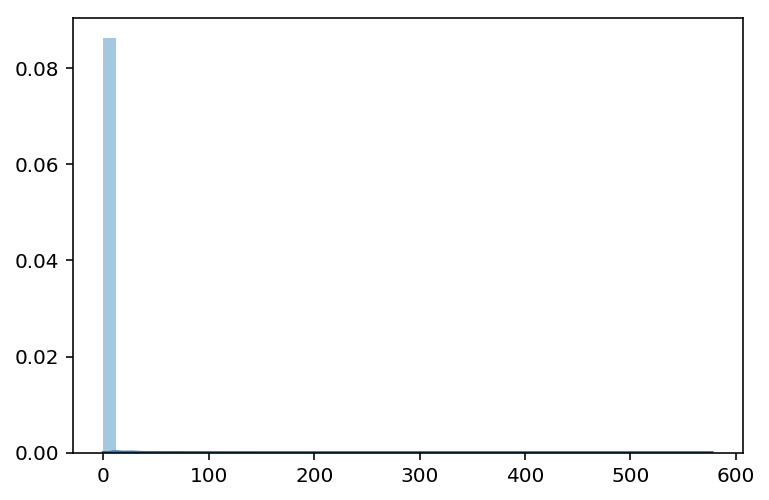

In [53]:
sns.distplot(full_dist_diff[~np.isnan(full_dist_diff)])

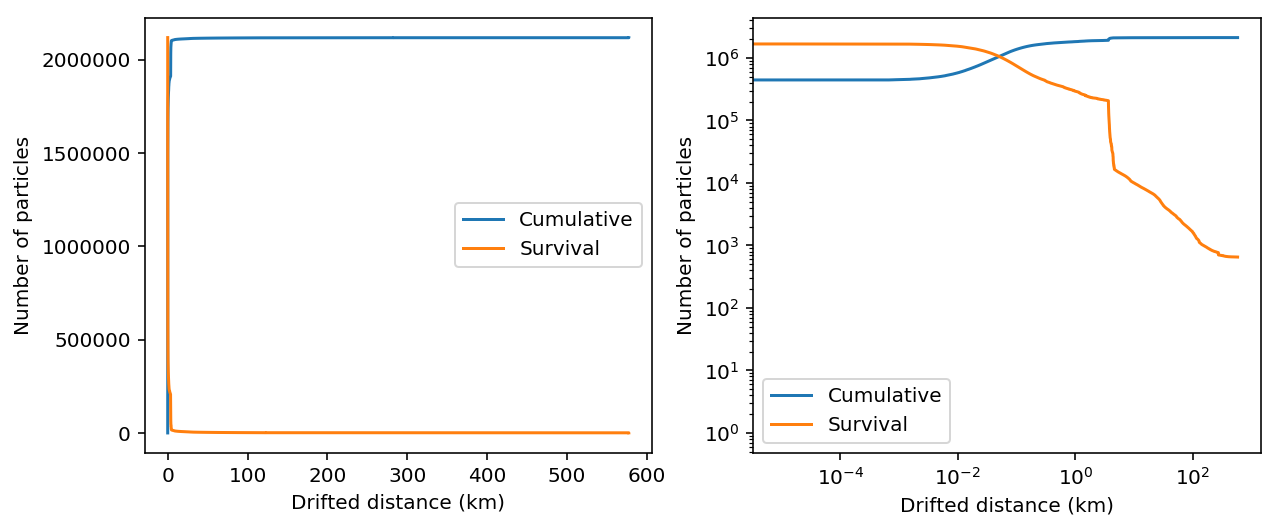

In [54]:
sorted_dists = np.sort(full_dist_diff)  # Or data.sort(), if data can be modified
fig, axes = plt.subplots(1,2, figsize=(10,4))
axes[0].step(sorted_dists, np.arange(sorted_dists.size), label='Cumulative')  # From 0 to the number of data points-1
axes[0].step(sorted_dists[::-1], np.arange(sorted_dists.size), label='Survival')  # From the number of data points-1 to 0
axes[0].set_xlabel('Drifted distance (km)')
axes[0].set_ylabel('Number of particles')
axes[0].legend()
axes[1].loglog(sorted_dists, np.arange(sorted_dists.size), label='Cumulative')  # From 0 to the number of data points-1
axes[1].loglog(sorted_dists[::-1], np.arange(sorted_dists.size), label='Survival')  # From the number of data points-1 to 0
axes[1].set_xlabel('Drifted distance (km)')
axes[1].set_ylabel('Number of particles')
axes[1].legend()
plt.show()

# Full particle set comparison
We also checked advection timesteps of 1 and 20 seconds. 1s can be used as our best benchmark, while 5s, 20s and 60s are compared against this time.

In [61]:
final_loc = {'1' : (ds_dt1.lon[:,-1], ds_dt1.lat[:,-1]),
             '5' : (ds_dt5.lon[:,-1], ds_dt1.lat[:,-1]),
             '20' : (ds_dt20.lon[:,-1], ds_dt1.lat[:,-1]),
             '60a' : (ds_dt60a.lon[:,-1], ds_dt1.lat[:,-1]),
             '60b' : (ds_dt60b.lon[:,-1], ds_dt1.lat[:,-1]),
         }

In [ ]:
dist_diff = {}
for combo in combinations(psets.keys(), 2):
    dist_diff[combo] = haversine(final_loc[combo[0]][0],
                                 final_loc[combo[0]][1],
                                 final_loc[combo[1]][0],
                                 final_loc[combo[1]][1])

In [63]:
sorted_dist_diff = {}
for key in dist_diff:
    sorted_dist_diff[key] = np.sort(dist_diff[key])

In [ ]:
fig, axes = plt.subplots(1,2, figsize=(12,5))
for key in dist_diff.keys():
    axes[0].step(sorted_dist_diff[key], np.arange(sorted_dist_diff[key].size), label=f'Cumulative ({key[0]}-{key[1]})')
    axes[0].step(sorted_dist_diff[key][::-1], np.arange(sorted_dist_diff[key].size), label=f'Survival ({key[0]}-{key[1]})')
axes[0].set_xlabel('Drifted distance (km)')
axes[0].set_ylabel('Number of particles')
axes[0].legend()

for key in dist_diff.keys():
    axes[1].loglog(sorted_dist_diff[key], np.arange(sorted_dist_diff[key].size), label=f'Cumulative ({key[0]}-{key[1]})')
    axes[1].loglog(sorted_dist_diff[key][::-1], np.arange(sorted_dist_diff[key].size), label=f'Survival ({key[0]}-{key[1]})')
axes[1].set_xlabel('Drifted distance (km)')
axes[1].set_ylabel('Number of particles')
axes[1].legend()
plt.show()

# Influence on communities

In [ ]:
readdir_ice = '/data/oceanparcels/input_data/CESM/0.1_deg/control/ice/arctic/'
readdir_ocean = '/data/oceanparcels/input_data/CESM/0.1_deg/control/ocean/arctic/'
readdir_mesh = '/scratch/DaanR/fields/'

fieldfile_ocean = 'daily_CESM_0.1degree_controlrun_year_300_arctic_timed_no_cord.nc'
fieldfile_ice = 'monthly_icefields_CESM_0.1degree_controlrun_year_300_arctic.nc'
meshfile = 'POP_grid_coordinates.nc'

writedir = ''
fieldset = fieldsetter.read_velocity_field(readdir_ocean+fieldfile_ocean, meshfile=readdir_mesh+meshfile)  

In [ ]:
countG5 = comtools.countGrid(240, 40)
countG5.load_communities('../community_detection/out/graph_control_y300_P3590x590_S2000-7-1_D30_DT5_ODT12_LAT60.5-89.5_LON-179.5-179.5_C240x40.clu')
countG5.find_adjacency();
countG5.color_communities();

In [ ]:
fig, ax = plot.from_dataset(countG5.lonBounds, 
                            countG5.latBounds, 
                            countG5.recoloredCommunityMap, 
                            colormap = 'prism', 
                            title = 'Communities detected by InfoMap',
                            polar = True, 
                            land = True, 
                            latRange = (60,90),
                            cbar = False)